<a href="https://colab.research.google.com/github/TerryTian21/DataScience/blob/main/Notebooks/Credit_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Default Prediction

With the [kaggle dataset](https://www.kaggle.com/datasets/nikhil1e9/loan-default) we will attempt to build a model to predict the likelihood of an individual defaulting on their loans.

## Import Libraries and Obtain Data

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn

In [2]:
import requests
import zipfile
import io

url = "https://github.com/TerryTian21/DataScience/raw/main/Data/CreditDefault.zip"

response = requests.get(url)
zip_file_bytes = io. BytesIO(response.content)

with zipfile.ZipFile(zip_file_bytes, 'r') as zipf:
    zipf.extractall("./data")


In [3]:
df = pd.read_csv("./data/Loan_default.csv")
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

## EDA

Start by plotting all the numeric variables as a histogram to evalute the shape of the data.

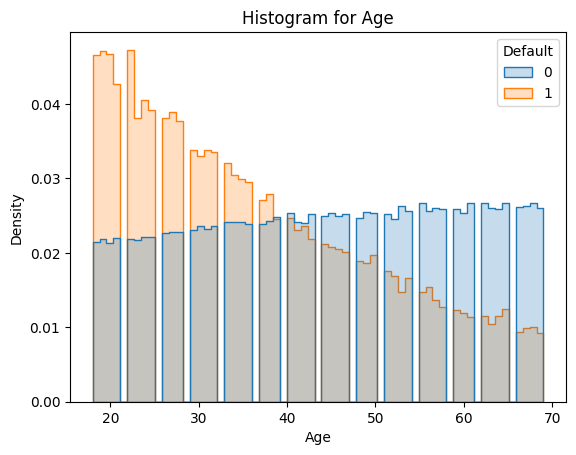

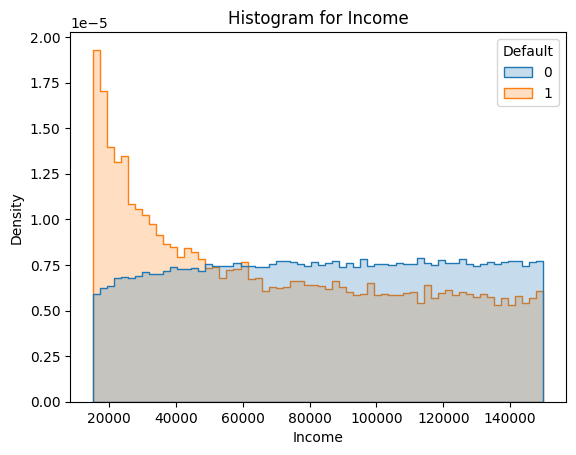

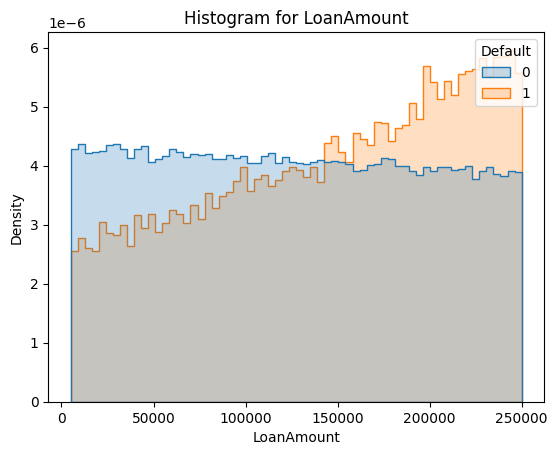

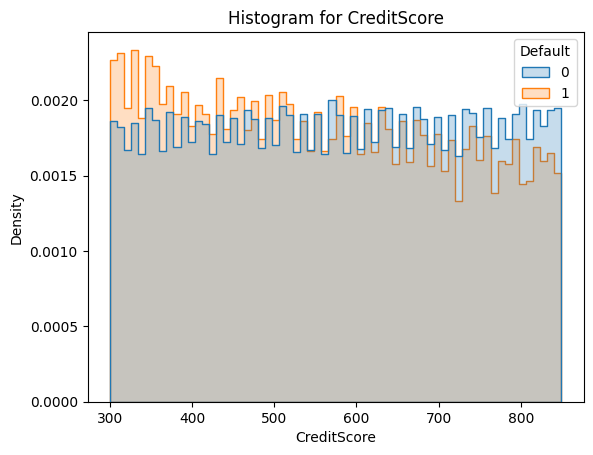

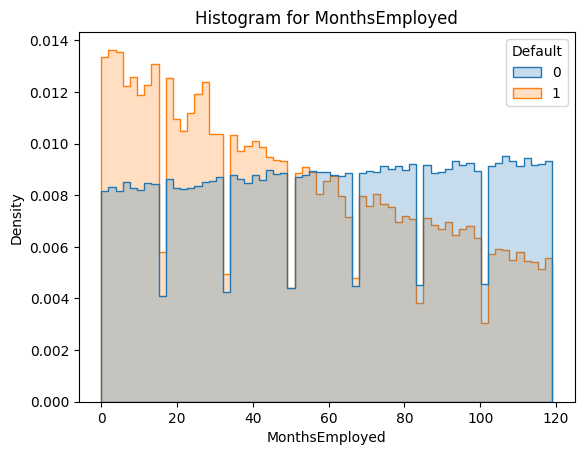

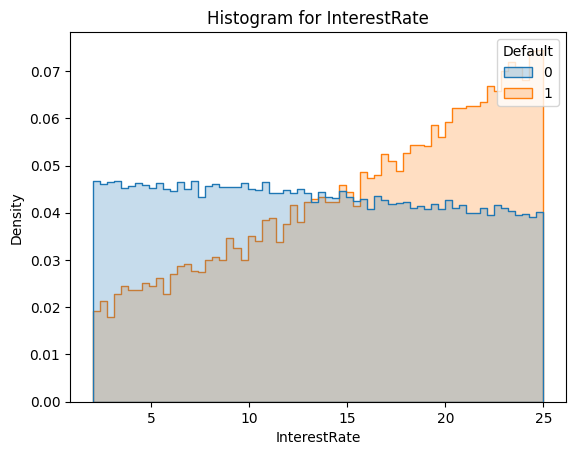

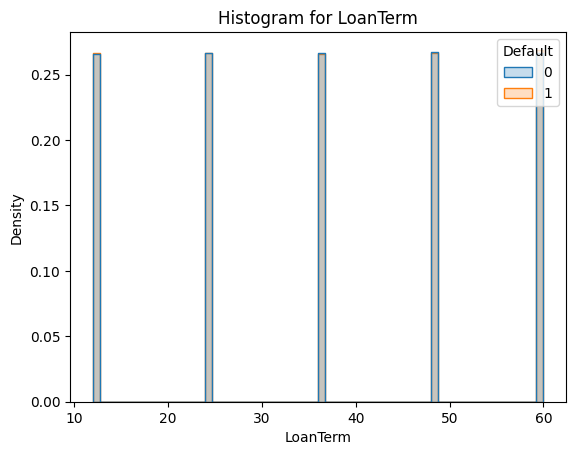

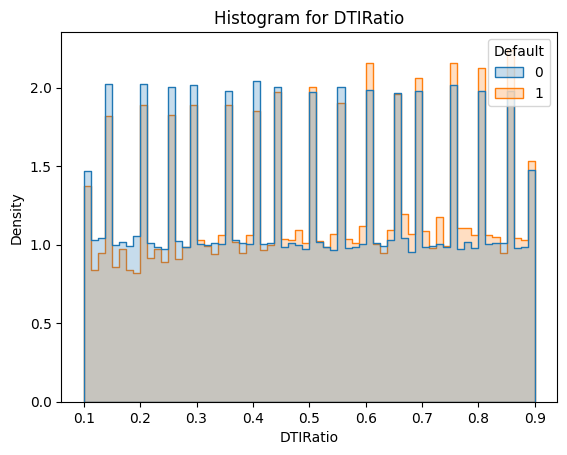

In [5]:
import seaborn as sns

numeric_columns = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed", "InterestRate", "LoanTerm", "DTIRatio"]

for column in numeric_columns:
  sns.histplot(data=df, x=column, hue="Default", element="step", stat="density", common_norm=False)
  plt.xlabel(column)
  plt.ylabel("Density")
  plt.title(f"Histogram for {column}")
  plt.show()


We are looking for differences between each of the categories. If, one category differes significantly in distribution for "Defaults", then using said category as a "one-hot-feature" could help us perform the classification

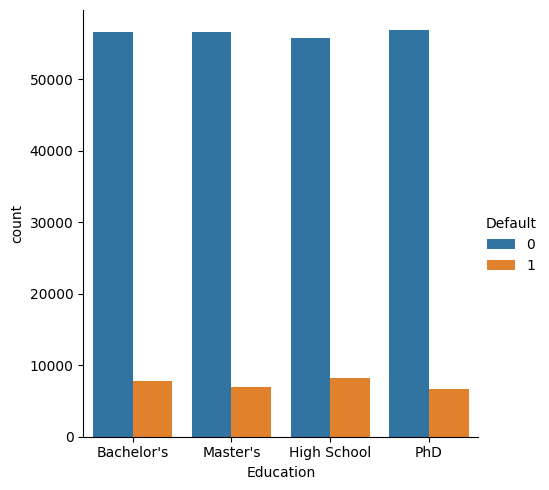

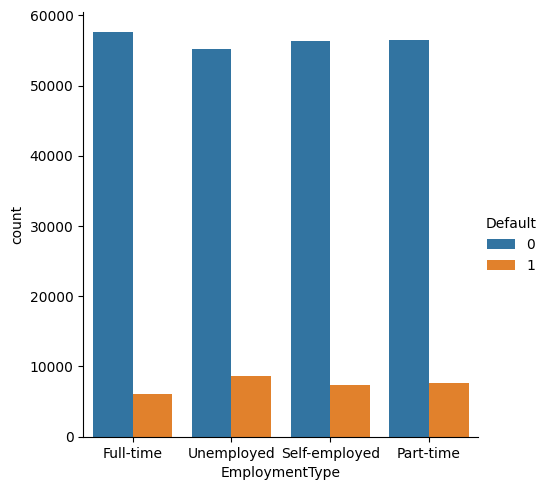

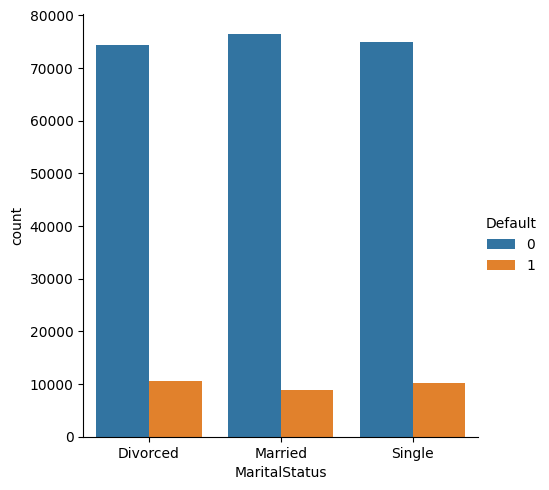

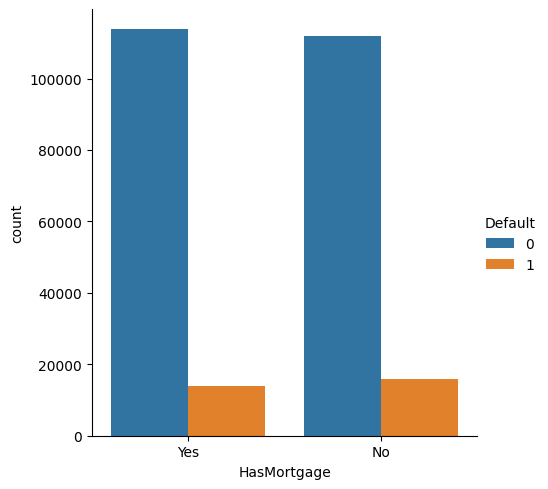

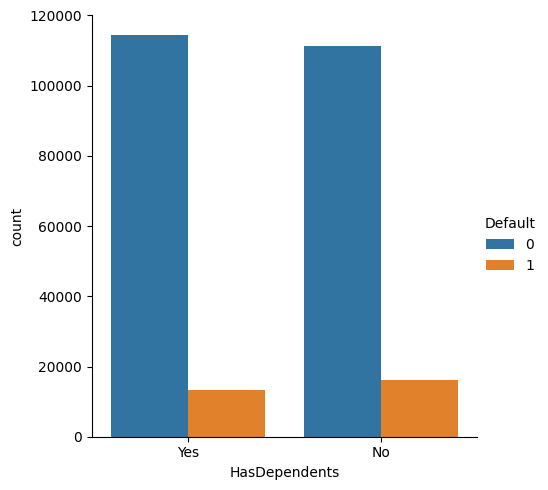

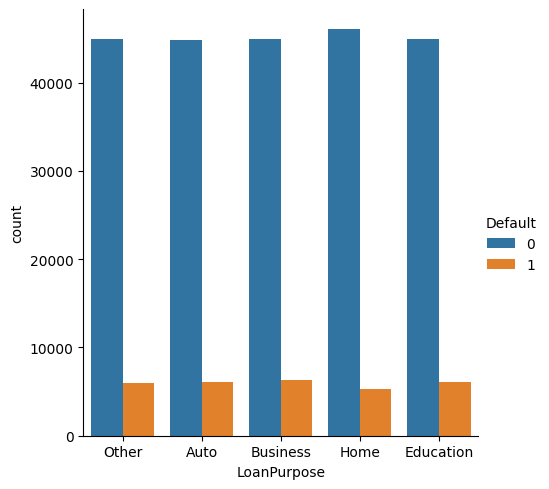

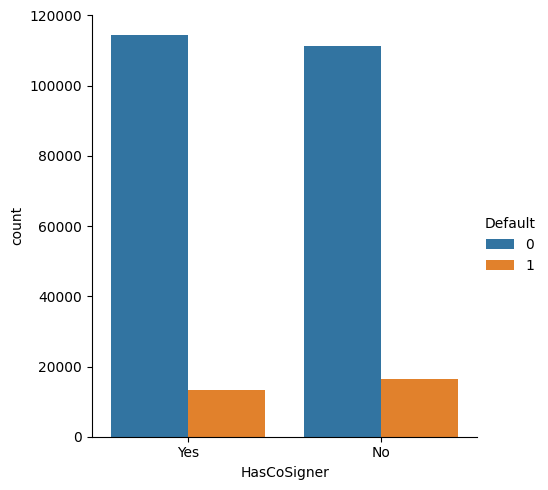

In [6]:
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

for column in categorical_columns:
  sns.catplot(data=df, x=column, hue="Default", kind="count")

We are looking for significant differences between the histograms of "Default" vs "No Default". If there is a difference in means, IQR size, or outliers, it could indicate a valuable feature for classification.

In [7]:
df.columns

Index(['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore',
       'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
       'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner',
       'Default'],
      dtype='object')

  0%|          | 0/8 [00:00<?, ?it/s]

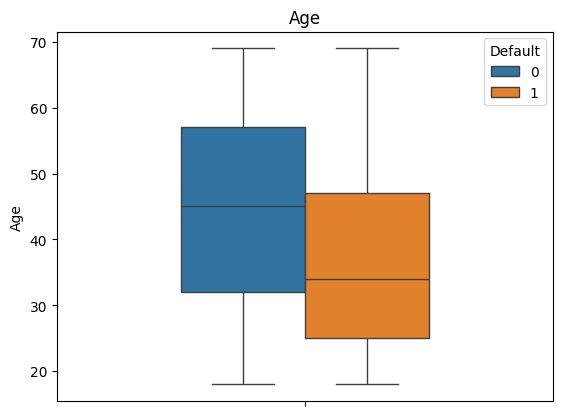

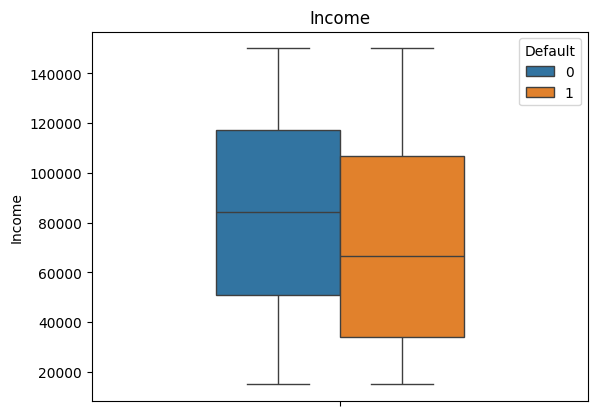

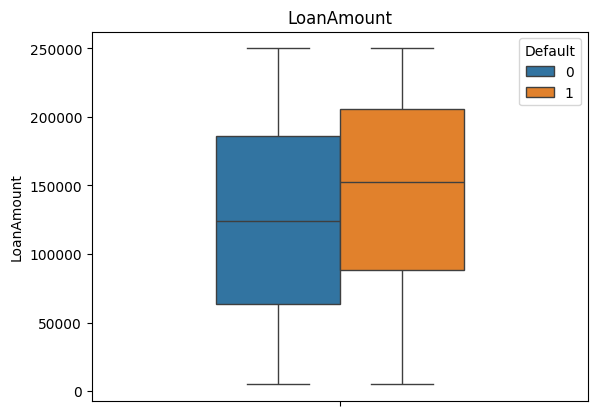

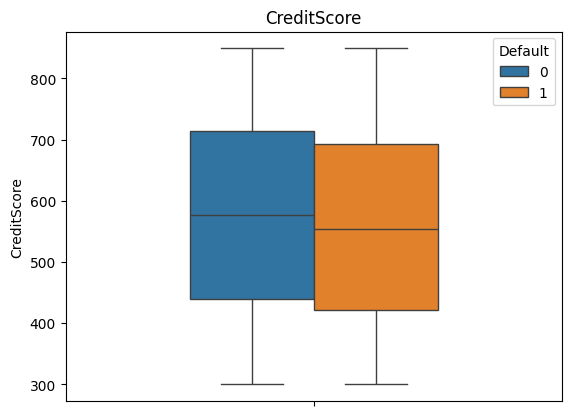

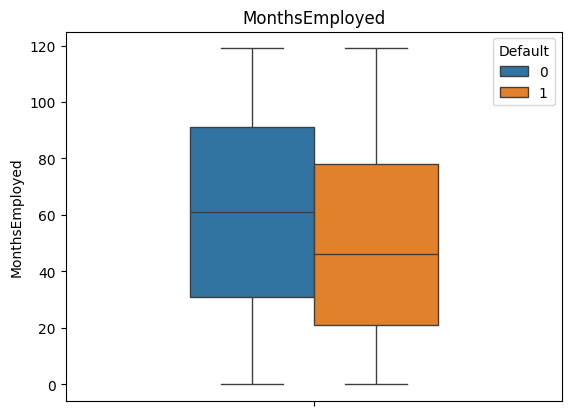

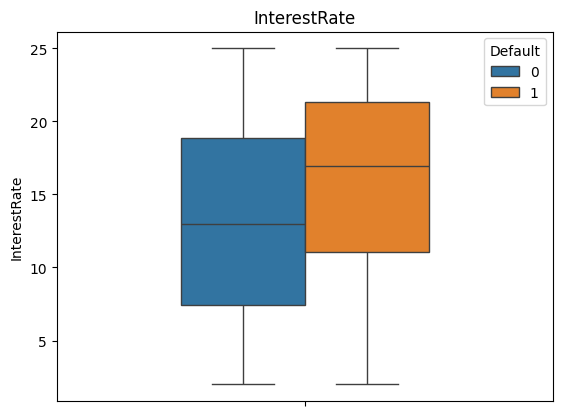

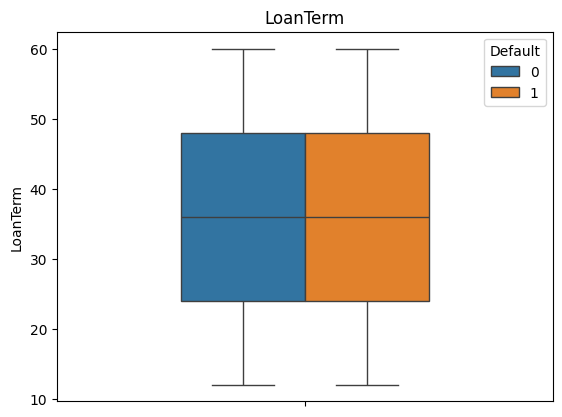

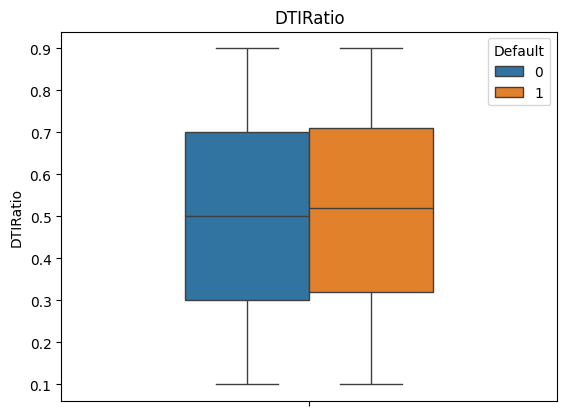

In [8]:
from tqdm.auto import tqdm

for column in tqdm(numeric_columns):
  sns.boxplot(data=df, y=column, hue="Default", width=0.5)
  plt.title(column)
  plt.show()

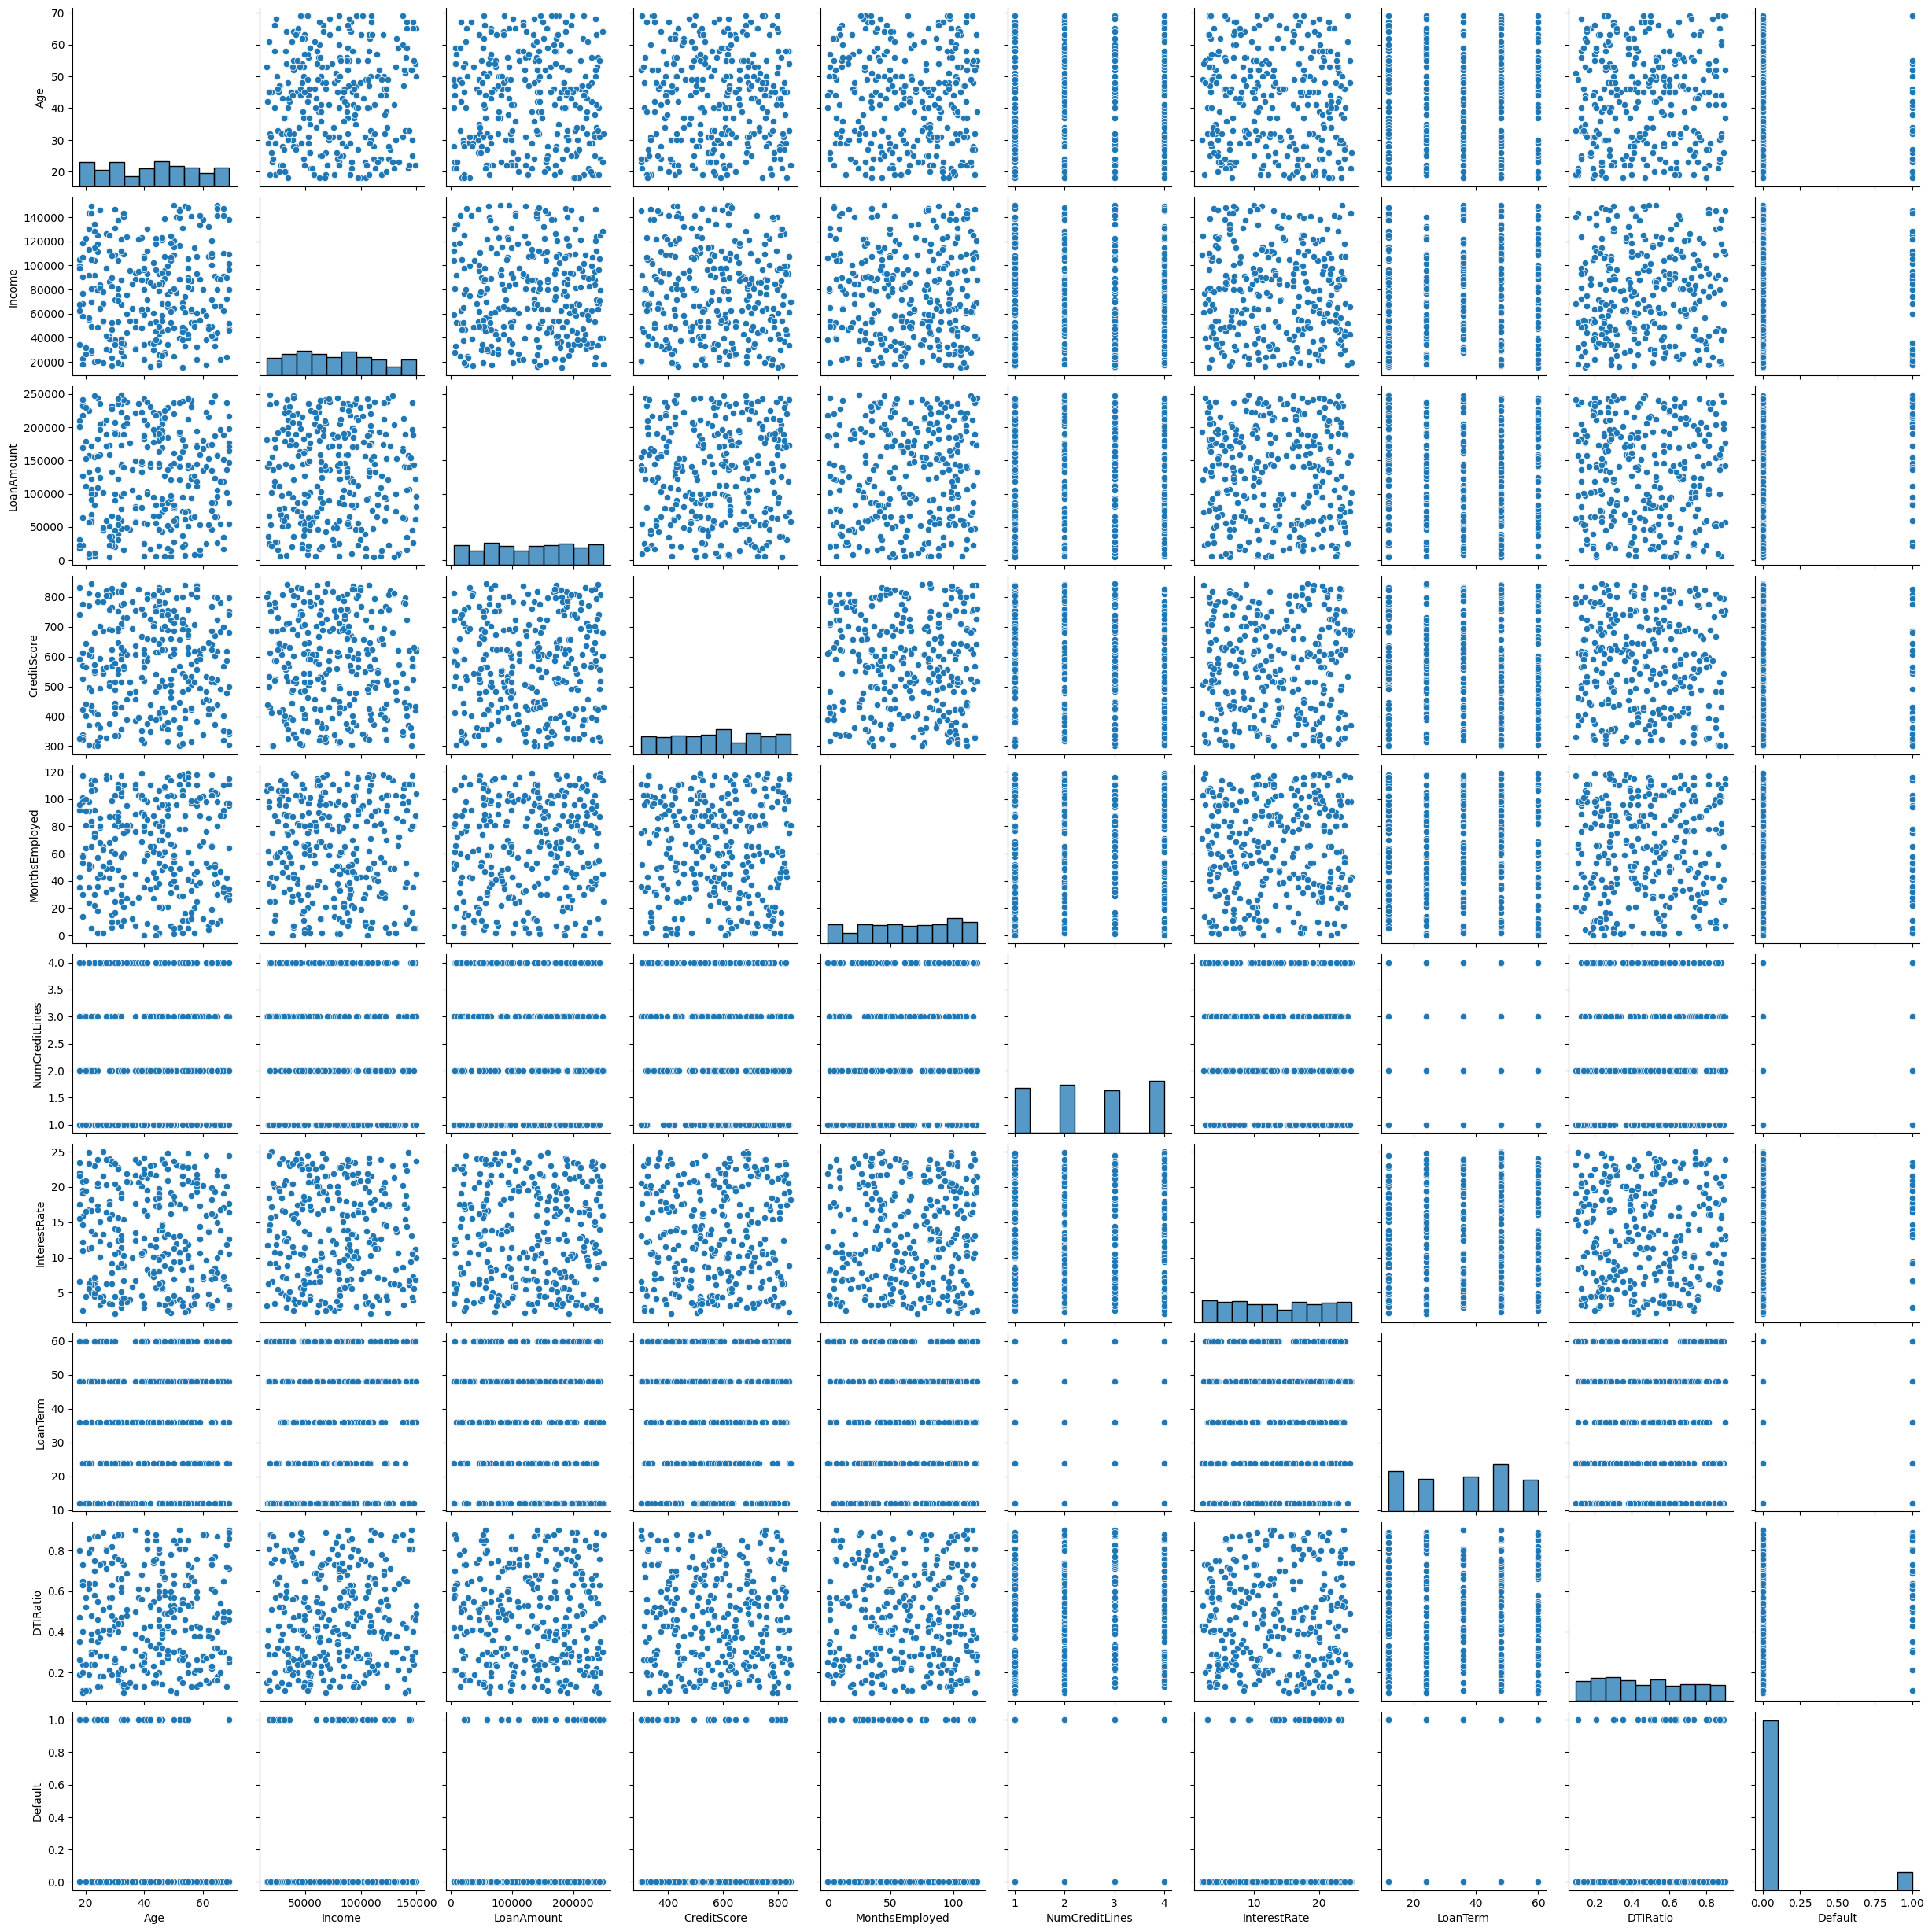

In [9]:
subset = df.sample(300)
sns.pairplot(subset)

## Feature Selection

Referencing the Univariate Feature Selection methods presented here:

https://medium.com/@shiwanigupta3005/feature-selection-techniques-for-classification-models-832ebfc6564d

In [10]:
# Data Preprocessing
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
df_noID = df.drop("LoanID", axis=1)

oe.fit(df_noID)
encoded_array = oe.transform(df_noID)
encoded_df = pd.DataFrame(encoded_array, columns=df_noID.columns)


In [11]:
encoded_df.head(10)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,38.0,60221.0,29657.0,220.0,80.0,3.0,1323.0,2.0,34.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0,0.0
1,51.0,30083.0,77402.0,158.0,15.0,0.0,281.0,4.0,58.0,2.0,0.0,1.0,0.0,0.0,4.0,1.0,0.0
2,28.0,58702.0,80425.0,151.0,26.0,2.0,1917.0,1.0,21.0,2.0,3.0,0.0,1.0,1.0,0.0,0.0,1.0
3,14.0,14248.0,25896.0,443.0,0.0,2.0,507.0,1.0,13.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,42.0,4654.0,2703.0,333.0,8.0,3.0,451.0,3.0,63.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0
5,7.0,63875.0,55410.0,420.0,18.0,1.0,2072.0,1.0,0.0,1.0,3.0,2.0,1.0,0.0,1.0,1.0,1.0
6,20.0,81672.0,111325.0,129.0,80.0,0.0,1711.0,0.0,6.0,0.0,3.0,2.0,1.0,0.0,3.0,1.0,0.0
7,38.0,94992.0,97513.0,231.0,67.0,3.0,615.0,4.0,33.0,3.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0
8,18.0,22999.0,56653.0,527.0,83.0,0.0,2194.0,3.0,10.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,1.0
9,22.0,100028.0,144707.0,180.0,114.0,3.0,709.0,3.0,23.0,1.0,2.0,1.0,1.0,0.0,4.0,1.0,0.0


### Variance Threshold

When a feature doesn't vary much within itself, it generally has little predictive power.

Since standard deviation and variance depend on the mean, these statistics should not be used for categorical data.

In [12]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.8)
selector.fit(df[numeric_columns])
for item in zip(numeric_columns, selector.get_support()):
  print(item)

('Age', True)
('Income', True)
('LoanAmount', True)
('CreditScore', True)
('MonthsEmployed', True)
('InterestRate', True)
('LoanTerm', True)
('DTIRatio', False)


### Fisher Score/Chi Square

Measures the ratio of variance to variance between for **2 categorical variables**

Reference: https://machinelearningmastery.com/feature-selection-with-categorical-data/

In [13]:
from sklearn.feature_selection import SelectKBest, chi2

# Select top 5 features
selector = SelectKBest(chi2, k=4)
selector.fit(encoded_df[categorical_columns], y=encoded_df["Default"])

for item in zip(categorical_columns, selector.get_support()):
  print(item)

('Education', True)
('EmploymentType', True)
('MaritalStatus', False)
('HasMortgage', False)
('HasDependents', True)
('LoanPurpose', False)
('HasCoSigner', True)


### Mutal Information

Computes how much knowing one variable reduces the uncertainty of another.

In [14]:
from sklearn.feature_selection import mutual_info_classif

MI = mutual_info_classif(encoded_df.drop("Default", axis=1), encoded_df['Default'])

In [15]:
MI = [item.round(3) for item in MI]

for item in sorted(list(zip(MI, encoded_df.drop("Default", axis=1).columns)), reverse=True):
  print(item)

(0.036, 'HasDependents')
(0.035, 'HasMortgage')
(0.035, 'HasCoSigner')
(0.017, 'MaritalStatus')
(0.015, 'Age')
(0.012, 'EmploymentType')
(0.011, 'NumCreditLines')
(0.011, 'Education')
(0.01, 'LoanTerm')
(0.01, 'LoanPurpose')
(0.008, 'InterestRate')
(0.008, 'Income')
(0.005, 'MonthsEmployed')
(0.004, 'LoanAmount')
(0.001, 'DTIRatio')
(0.0, 'CreditScore')


### ANOVA

Analysis of Variance is a statistical test used to evalute difference between means of more than 2 groups. It splits the dataset into 2 parts:
- Systematic factors : Influence given data
- Random factors : Do not influence dataset

The ANOVA test allows for comparison of two or more groups to determine if a relationship exists between them. The result of the test is called **F Statistic**.
- If no difference exists between tested groups (signs of correlation) the F statstic will be close to 1

We can use the ANOVA test when to perform feature selection when there exist: **Numeric Input, Categorical Output**

In [19]:
from sklearn.feature_selection import f_classif

fs = SelectKBest(score_func=f_classif, k=2)
fs.fit(encoded_df[numeric_columns], encoded_df["Default"])

for item in zip(numeric_columns, fs.get_support()):
  print(item)

('Age', True)
('Income', False)
('LoanAmount', False)
('CreditScore', False)
('MonthsEmployed', False)
('InterestRate', True)
('LoanTerm', False)
('DTIRatio', False)


## Create Train, Test and Validation Datasets

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = list(encoded_df.drop("Default", axis=1))
X = encoded_df.drop("Default", axis=1).to_numpy()
y = encoded_df["Default"].to_numpy()

# Scale Data
X = StandardScaler().fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Verify the shape of each train/valid/test sets are correct

In [59]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(178742, 16)
(38302, 16)
(38303, 16)


In [60]:
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(178742,)
(38302,)
(38303,)


## Examine Models

We will explore four different models and explore which model has the best predictive power over a user's likelihood for defaulting.

### Logistic Regression

Let's start by performing univariate linear regression, then we can move onto multivariate regression. We will use age as the predictor of probability of defaulting.


Text(0, 0.5, 'default')

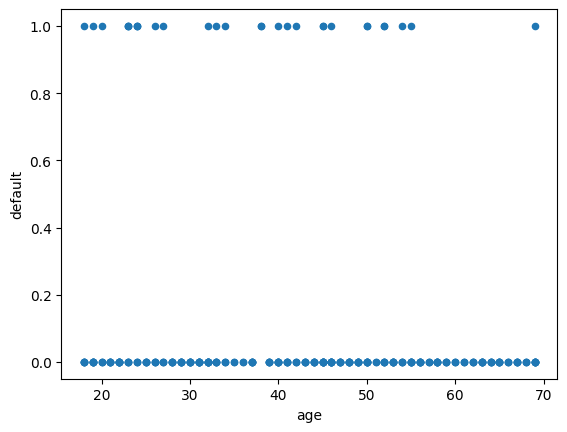

In [63]:
# Visualize the plot between age and default

plt.scatter(subset["Age"], subset["Default"], s=20)
plt.xlabel("age")
plt.ylabel("default")

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define Input Features
input = X_train[:, 0].reshape(-1,1)

# Create model
model = LogisticRegression().fit(input, y_train)
train_preds = model.predict(input)
valid_preds = model.predict(X_valid[:, 0].reshape(-1,1))

# Get accuracy
print(f"The train accuracy is {accuracy_score(y_train, train_preds)}")
print(f"The validation accuracy is {accuracy_score(y_valid, valid_preds)}")

The train accuracy is 0.884028376095154
The validation accuracy is 0.8819643882825962


Given our set of features, we will use RFE (recursive feature elimination) to find the best possible regression model. When utilizing RFE there are 2 hyperparameters to optimize:
- Number of Features
- Choice of Algorithm

First we will fix the number of features to 1, then demonstate how we can automatically select. the number of features based on the accuracy vs complexity tradeoff.

Utilizing the `Pipeline` object, we can sequentially apply a list of transformers to preprocess the data, and conclude the sequence with a predictor.

Source : https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [65]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

rfe = RFE(estimator=LogisticRegression(), n_features_to_select=1)
model = LogisticRegression()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# Identify the the best feature
rfe.fit(X_train,  y_train)
for item in zip(features, rfe.support_):
  print(item)

('Age', True)
('Income', False)
('LoanAmount', False)
('CreditScore', False)
('MonthsEmployed', False)
('NumCreditLines', False)
('InterestRate', False)
('LoanTerm', False)
('DTIRatio', False)
('Education', False)
('EmploymentType', False)
('MaritalStatus', False)
('HasMortgage', False)
('HasDependents', False)
('LoanPurpose', False)
('HasCoSigner', False)


In [66]:
rfe.ranking_

array([ 1,  3,  5,  9,  4, 10,  2, 16, 13, 12,  6, 15, 11,  8, 14,  7])

In [69]:
# Fit data
pipeline.fit(X_train, y_train)

# Predict
train_preds = pipeline.predict(X_train)
valid_preds = pipeline.predict(X_valid)

# Get Accuracy
print(f"Train accuracy is {accuracy_score(y_train, train_preds)}")
print(f"Valid accuracy is {accuracy_score(y_valid, valid_preds)}")

Train accuracy is 0.884028376095154
Valid accuracy is 0.8819643882825962


Let's create a set of models and explore the distribution of accuracy for each number of features

In [82]:
def get_models():
  models = {}
  for i in range(2, 16):
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=i)
    model = LogisticRegression()
    models[str(i)] = Pipeline(steps=[('s', rfe), ('m', model)])
  return models

def evaluate_model(model, X_train, y_train, X_valid, y_valid):
  model.fit(X_train, y_train)
  preds = model.predict(X_valid)
  return accuracy_score(y_valid, preds)

# Initialize variables
models = get_models()
results, names = [], []

#Evaluate models
for name, model in tqdm(models.items()):
  scores = evaluate_model(model, X_train, y_train, X_valid, y_valid)
  results.append(scores)
  names.append(name)

  0%|          | 0/14 [00:00<?, ?it/s]

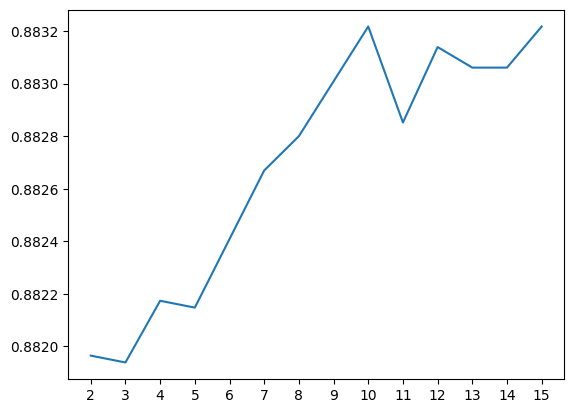

In [83]:
plt.plot(names, results)
plt.show()

Demonstate Automatic Optimization for Selection of Number of Features

In [89]:
from sklearn.feature_selection import RFECV

model = LogisticRegression()
rfe = RFECV(estimator=LogisticRegression())
pipeline = Pipeline(steps=[('s', rfe), ('m', model)])

rfe.fit(X_train, y_train)

for item in zip(features, rfe.support_):
  print(item)

('Age', True)
('Income', True)
('LoanAmount', True)
('CreditScore', True)
('MonthsEmployed', True)
('NumCreditLines', True)
('InterestRate', True)
('LoanTerm', True)
('DTIRatio', True)
('Education', True)
('EmploymentType', True)
('MaritalStatus', True)
('HasMortgage', True)
('HasDependents', True)
('LoanPurpose', True)
('HasCoSigner', True)


**Conclusion**:

The majority of logistic regression models (regardless of number of features) have very similar performance on both the train and validation datasets - hovering around 88%. The variance in accuracy is minimal and hence, there is no way to identify the optimal features to use.

The best performance was produced from utilizing all 15 features, yet the difference between best and worse performance is 0.1%. Hence, a univariate model using age as the only feature captures the same accuracy as a model that utilizes all 15 features. In a production environment, we would likely prefer the speed optimization from utilizing a single feature, over the marginal improvement in accuracy.


### Random Forest

Examine the performance of decision trees.

In [92]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=42)
clf.fit(X_train,y_train)

train_preds = clf.predict(X_train)
valid_preds = clf.predict(X_valid)

print(f"Train accuracy is {accuracy_score(y_train, train_preds)}")
print(f"Valid accuracy is {accuracy_score(y_valid, valid_preds)}")

Train accuracy is 0.884028376095154
Valid accuracy is 0.8819643882825962


Tune Hyperparameters

In [95]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators" : [10, 20],
    "max_depth": [3, 5, 10, 15, 20],
    "criterion": ["entropy", "gini"]
}

search = GridSearchCV(RandomForestClassifier(), param_grid)
search.fit(X_train, y_train)
results = search.cv_results_

results_df = pd.DataFrame(results)

In [99]:
results_df[["params", "rank_test_score"]].sort_values("rank_test_score")

,params,rank_test_score
5,"{'criterion': 'entropy', 'max_depth': 10, 'n_e...",1
7,"{'criterion': 'entropy', 'max_depth': 15, 'n_e...",2
15,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",3
17,"{'criterion': 'gini', 'max_depth': 15, 'n_esti...",4
4,"{'criterion': 'entropy', 'max_depth': 10, 'n_e...",5
14,"{'criterion': 'gini', 'max_depth': 10, 'n_esti...",6
9,"{'criterion': 'entropy', 'max_depth': 20, 'n_e...",7
12,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",8
19,"{'criterion': 'gini', 'max_depth': 20, 'n_esti...",9
6,"{'criterion': 'entropy', 'max_depth': 15, 'n_e...",10


from matplotlib import pyplot as plt
_df_0['rank_test_score'].plot(kind='hist', bins=20, title='rank_test_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['rank_test_score']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'rank_test_score'}, axis=1)
              .sort_values('rank_test_score', ascending=True))
  xs = counted['rank_test_score']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('rank_test_score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rank_test_score')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_2['rank_test_score'].plot(kind='line', figsize=(8, 4), title='rank_test_score')
plt.gca().spines[['top', 'right']].set_visible(False)

In [100]:
search.best_score_

0.8854438267921451

In [102]:
params = search.best_params_
params

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}

In [107]:
clf = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200)
clf.fit(X_train, y_train)
preds = clf.predict(X_valid)
print(f'Valid Accuracy is {accuracy_score(y_valid, preds)}')

Valid Accuracy is 0.8832175865490053
